<a href="https://colab.research.google.com/github/jhtwiz/hanghaeAI/blob/main/1%E1%84%8C%E1%85%AE%E1%84%8E%E1%85%A1_%E1%84%89%E1%85%B5%E1%86%B7%E1%84%92%E1%85%AA_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:03<00:00, 47648909.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print(trainset.classes)
print(len(trainset.classes))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


50000
torch.Size([3, 32, 32]) 9


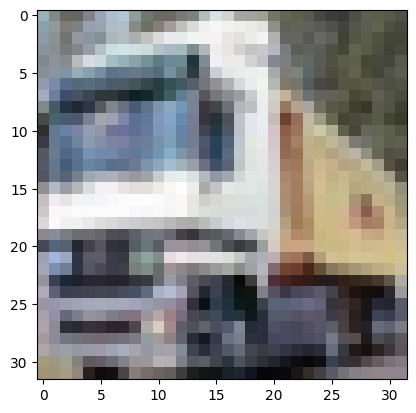

In [53]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[1][1])
sample = np.transpose(trainset[1][0], (1,2,0))
plt.imshow(sample)
# plt.imshow(trainset[0][0][0], cmap='gray')

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [6]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

In [7]:
from torch.optim import SGD, Adam

lr = 0.001

model_opt_sgd = Model(3 * 32 * 32, 1024)
model_opt_adam = Model(3 * 32 * 32, 1024)

model_opt_sgd = model_opt_sgd.to('cuda')
model_opt_adam = model_opt_adam.to('cuda')

optimizer_sgd = SGD(model_opt_sgd.parameters(), lr=lr)
optimizer_adam = Adam(model_opt_adam.parameters(), lr=lr)

In [8]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [54]:
def train(model, optimizer, trainloader, testloader=None, n_epochs = 50):
    train_accs = []
    test_accs = []
    for epoch in range(n_epochs):
      total_loss = 0.

      model.train()
      for data in trainloader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        CEL = torch.nn.CrossEntropyLoss()
        loss = CEL(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      with torch.no_grad():
        model.eval()
        train_accs.append(accuracy(model, trainloader))
        if testloader: test_accs.append(accuracy(model, testloader))

      print(f"Epoch {epoch:3d} | Loss: {total_loss}")

    if testloader:
        return train_accs, test_accs
    else:
        return train_accs

In [55]:
adam_train = train(model_opt_adam, optimizer_adam, trainloader)
sgd_train = train(model_opt_sgd, optimizer_sgd, trainloader)

Epoch   0 | Loss: 367.0311794281006
Epoch   1 | Loss: 324.82584738731384
Epoch   2 | Loss: 306.79751443862915
Epoch   3 | Loss: 293.45182621479034
Epoch   4 | Loss: 284.31485414505005
Epoch   5 | Loss: 277.8920427560806
Epoch   6 | Loss: 268.2720561027527
Epoch   7 | Loss: 262.4468505382538
Epoch   8 | Loss: 256.1656517982483
Epoch   9 | Loss: 250.10444974899292
Epoch  10 | Loss: 244.32118546962738
Epoch  11 | Loss: 237.65973526239395
Epoch  12 | Loss: 232.43983149528503
Epoch  13 | Loss: 228.81709772348404
Epoch  14 | Loss: 223.52175897359848
Epoch  15 | Loss: 216.3493590950966
Epoch  16 | Loss: 210.8979938030243
Epoch  17 | Loss: 205.59054082632065
Epoch  18 | Loss: 200.270736515522
Epoch  19 | Loss: 196.08723652362823
Epoch  20 | Loss: 189.00767332315445
Epoch  21 | Loss: 183.3493709564209
Epoch  22 | Loss: 178.43980413675308
Epoch  23 | Loss: 173.29650431871414
Epoch  24 | Loss: 166.67488372325897
Epoch  25 | Loss: 162.2826133966446
Epoch  26 | Loss: 158.2842692732811
Epoch  27 | L

In [56]:
from matplotlib import pyplot as plt

def showPlot(*results):
    for result in results:
        data = result['data']
        label = result['label']
        x = np.arange(len(data))
        plt.plot(x, data, label=label)
    plt.legend()
    plt.show()

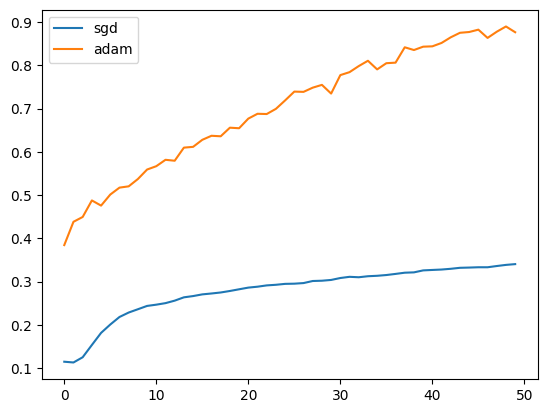

In [57]:
showPlot({'label': 'sgd', 'data': sgd_train}, {'label': 'adam', 'data': adam_train})

In [58]:
class SigmoidModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.Sigmoid()


    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)

        return x

In [59]:
lr = 0.001

sigModel = SigmoidModel(3 * 32 * 32, 1024)
leakyReLUModel = Model(3 * 32 * 32, 1024)

sigModel = sigModel.to('cuda')
leakyReLUModel = leakyReLUModel.to('cuda')

optim_for_sig = Adam(sigModel.parameters(), lr=lr)
optim_for_leaky = Adam(leakyReLUModel.parameters(), lr=lr)

In [60]:
sig_train = train(sigModel, optim_for_sig, trainloader)
leaky_train = train(leakyReLUModel, optim_for_leaky, trainloader)

Epoch   0 | Loss: 382.9223313331604
Epoch   1 | Loss: 336.6852729320526
Epoch   2 | Loss: 317.0221310853958
Epoch   3 | Loss: 308.88440442085266
Epoch   4 | Loss: 295.5645318031311
Epoch   5 | Loss: 288.5786784887314
Epoch   6 | Loss: 282.3953174352646
Epoch   7 | Loss: 278.5399605035782
Epoch   8 | Loss: 271.5605546236038
Epoch   9 | Loss: 268.69135999679565
Epoch  10 | Loss: 263.9711526632309
Epoch  11 | Loss: 259.40839743614197
Epoch  12 | Loss: 254.0553719997406
Epoch  13 | Loss: 248.88220274448395
Epoch  14 | Loss: 247.19656443595886
Epoch  15 | Loss: 242.31439924240112
Epoch  16 | Loss: 238.22504210472107
Epoch  17 | Loss: 234.9828085899353
Epoch  18 | Loss: 232.77137053012848
Epoch  19 | Loss: 229.87593698501587
Epoch  20 | Loss: 224.4631580710411
Epoch  21 | Loss: 222.26711648702621
Epoch  22 | Loss: 218.26436066627502
Epoch  23 | Loss: 215.44781827926636
Epoch  24 | Loss: 211.6706850528717
Epoch  25 | Loss: 206.85522907972336
Epoch  26 | Loss: 203.87952876091003
Epoch  27 | Lo

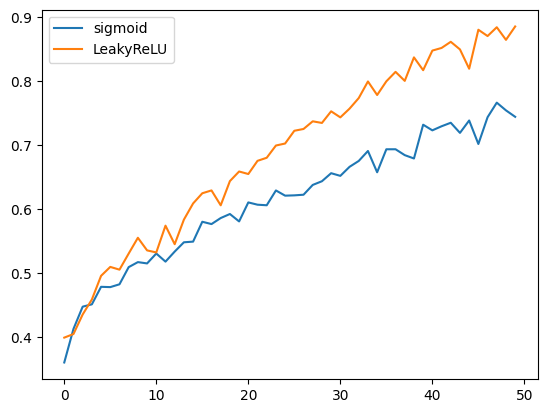

In [61]:
showPlot({'label': 'sigmoid', 'data': sig_train}, {'label': 'LeakyReLU', 'data': leaky_train})

In [62]:
class DropoutModel(nn.Module):

    def __init__(self, input_dim, n_dim, dropout_p = 0.1):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.dropout(x)
        x = self.act(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)

        return x

In [63]:
dropoutModel = DropoutModel(3 * 32 * 32, 1024)
dropoutModel = dropoutModel.to('cuda')

optim_with_drop = Adam(dropoutModel.parameters(), lr=lr)

In [64]:
train_data, test_data = train(dropoutModel, optim_with_drop, trainloader, testloader)

Epoch   0 | Loss: 370.6052612066269
Epoch   1 | Loss: 331.5096263885498
Epoch   2 | Loss: 315.61449551582336
Epoch   3 | Loss: 303.3977918624878
Epoch   4 | Loss: 296.68129217624664
Epoch   5 | Loss: 290.4642720222473
Epoch   6 | Loss: 283.93445348739624
Epoch   7 | Loss: 279.28534257411957
Epoch   8 | Loss: 274.4852958917618
Epoch   9 | Loss: 269.98172330856323
Epoch  10 | Loss: 265.44450092315674
Epoch  11 | Loss: 261.6225061416626
Epoch  12 | Loss: 258.73017704486847
Epoch  13 | Loss: 254.68715798854828
Epoch  14 | Loss: 251.13551437854767
Epoch  15 | Loss: 247.88894605636597
Epoch  16 | Loss: 244.9685606956482
Epoch  17 | Loss: 240.44724249839783
Epoch  18 | Loss: 238.13827621936798
Epoch  19 | Loss: 234.76008462905884
Epoch  20 | Loss: 230.17862355709076
Epoch  21 | Loss: 229.9167588353157
Epoch  22 | Loss: 225.3231937289238
Epoch  23 | Loss: 222.7356950044632
Epoch  24 | Loss: 218.61170780658722
Epoch  25 | Loss: 217.4084882736206
Epoch  26 | Loss: 213.6006487607956
Epoch  27 | L

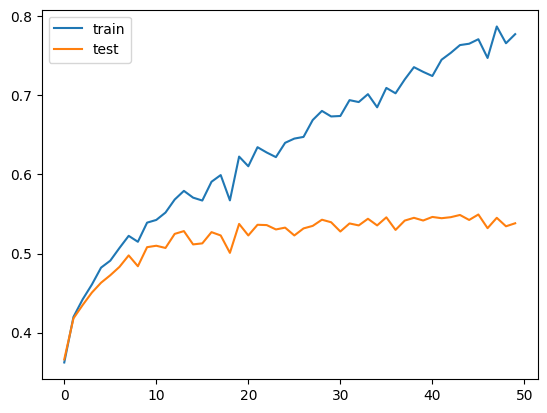

In [65]:
showPlot({'label': 'train', 'data': train_data}, {'label': 'test', 'data': test_data})

여기서부터는 과제 외의 부분입니다

In [47]:
dropoutModel2 = DropoutModel(3 * 32 * 32, 1024, 0.2)
dropoutModel2 = dropoutModel2.to('cuda')

optim_with_drop2 = Adam(dropoutModel2.parameters(), lr=lr)
train2, test2 = train(dropoutModel2, optim_with_drop2, trainloader, testloader)

Epoch   0 | Loss: 373.52413868904114
Epoch   1 | Loss: 335.6854910850525
Epoch   2 | Loss: 322.2049752473831
Epoch   3 | Loss: 314.35175931453705
Epoch   4 | Loss: 308.0481460094452
Epoch   5 | Loss: 301.982638835907
Epoch   6 | Loss: 296.8003523349762
Epoch   7 | Loss: 292.6875970363617
Epoch   8 | Loss: 287.3895571231842
Epoch   9 | Loss: 286.06273436546326
Epoch  10 | Loss: 283.10261142253876
Epoch  11 | Loss: 279.6125419139862
Epoch  12 | Loss: 278.18759739398956
Epoch  13 | Loss: 276.39577782154083
Epoch  14 | Loss: 272.4646316766739
Epoch  15 | Loss: 269.8173031806946
Epoch  16 | Loss: 268.2014310359955
Epoch  17 | Loss: 266.4161876440048
Epoch  18 | Loss: 262.88753855228424
Epoch  19 | Loss: 261.51274049282074
Epoch  20 | Loss: 258.52511751651764
Epoch  21 | Loss: 257.065313577652
Epoch  22 | Loss: 254.3892925977707
Epoch  23 | Loss: 251.40970063209534
Epoch  24 | Loss: 249.7251398563385
Epoch  25 | Loss: 249.0025213956833
Epoch  26 | Loss: 247.210853099823
Epoch  27 | Loss: 246

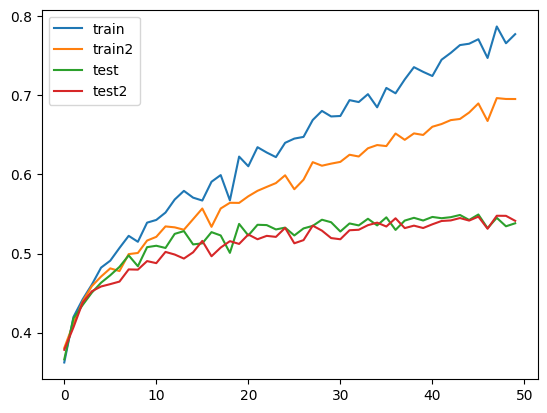

In [66]:
showPlot({'label': 'train', 'data': train_data}, {'label': 'train2', 'data': train2}, {'label': 'test', 'data': test_data}, {'label': 'test2', 'data': test2})

In [19]:
class TestModel(nn.Module):

    def __init__(self, input_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 10)

        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.dropout(x)
        x = self.act(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)

        return x


testModel = TestModel(3*32*32)
testModel = testModel.to('cuda')

optim_test = Adam(testModel.parameters(), lr=lr)

test_train, test_test = train(testModel, optim_test, trainloader, testloader)

Epoch   0 | Loss: 378.8021477460861
Epoch   1 | Loss: 341.34877729415894
Epoch   2 | Loss: 328.7953543663025
Epoch   3 | Loss: 317.83687472343445
Epoch   4 | Loss: 311.74602591991425
Epoch   5 | Loss: 307.90305829048157
Epoch   6 | Loss: 301.40583550930023
Epoch   7 | Loss: 298.6510292291641
Epoch   8 | Loss: 295.3452889919281
Epoch   9 | Loss: 292.6783570051193
Epoch  10 | Loss: 289.40399503707886
Epoch  11 | Loss: 287.1590670347214
Epoch  12 | Loss: 284.02955853939056
Epoch  13 | Loss: 283.0684597492218
Epoch  14 | Loss: 278.774551153183
Epoch  15 | Loss: 276.9377896785736
Epoch  16 | Loss: 275.2428060770035
Epoch  17 | Loss: 271.05774188041687
Epoch  18 | Loss: 269.1093821525574
Epoch  19 | Loss: 268.8155082464218
Epoch  20 | Loss: 267.47052669525146
Epoch  21 | Loss: 263.00065088272095
Epoch  22 | Loss: 263.8827885389328
Epoch  23 | Loss: 261.23248422145844
Epoch  24 | Loss: 260.43456768989563
Epoch  25 | Loss: 257.48164081573486
Epoch  26 | Loss: 255.42696619033813
Epoch  27 | Los

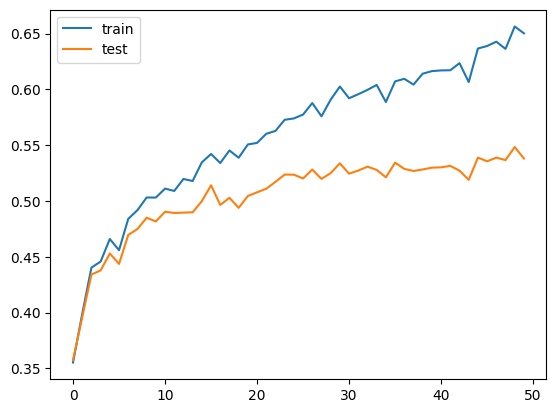

In [20]:
showPlot({'label': 'train', 'data': test_train}, {'label': 'test', 'data': test_test})

In [28]:
testModel2 = TestModel(3*32*32)
testModel2 = testModel2.to('cuda')

optim_test2 = Adam(testModel2.parameters(), lr=lr)

test_train2, test_test2 = train(testModel2, optim_test2, trainloader, testloader, 100)

Epoch   0 | Loss: 377.96220004558563
Epoch   1 | Loss: 343.78341460227966
Epoch   2 | Loss: 330.08819925785065
Epoch   3 | Loss: 320.55825901031494
Epoch   4 | Loss: 312.7025902271271
Epoch   5 | Loss: 306.41765546798706
Epoch   6 | Loss: 302.41309559345245
Epoch   7 | Loss: 299.7415443658829
Epoch   8 | Loss: 294.0254616737366
Epoch   9 | Loss: 292.2348133325577
Epoch  10 | Loss: 289.8039753437042
Epoch  11 | Loss: 286.1409046649933
Epoch  12 | Loss: 284.1549530029297
Epoch  13 | Loss: 280.8264685869217
Epoch  14 | Loss: 277.83416986465454
Epoch  15 | Loss: 277.2786021232605
Epoch  16 | Loss: 275.3087627887726
Epoch  17 | Loss: 273.6344676017761
Epoch  18 | Loss: 270.0747776031494
Epoch  19 | Loss: 269.489254117012
Epoch  20 | Loss: 267.0738273859024
Epoch  21 | Loss: 265.17625403404236
Epoch  22 | Loss: 264.9383203983307
Epoch  23 | Loss: 263.70169818401337
Epoch  24 | Loss: 262.2152969837189
Epoch  25 | Loss: 258.99933993816376
Epoch  26 | Loss: 257.59139370918274
Epoch  27 | Loss: 

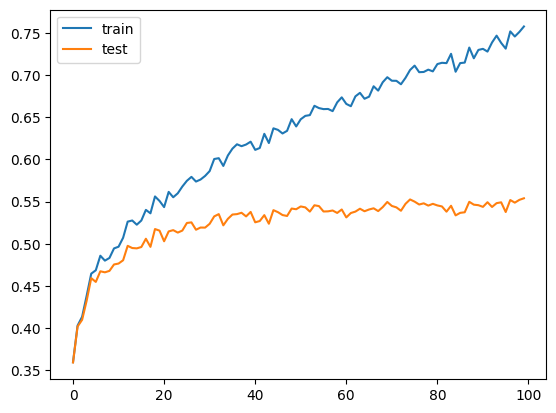

In [29]:
showPlot({'label': 'train', 'data': test_train2}, {'label': 'test', 'data': test_test2})

In [39]:
print(test_test2[-10:])

[0.5438, 0.5493, 0.5437, 0.5482, 0.5492, 0.5377, 0.5519, 0.5488, 0.5521, 0.554]
